# SVM. Hypersurfaces. Heatmap. GridSearch scores plot.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
# http://scikit-learn.org/stable/modules/svm.html

from sklearn.datasets.samples_generator import make_classification

X, y = make_classification(n_samples=50, n_features=2, n_informative=2, 
                            n_redundant=0, n_clusters_per_class=1, random_state=0)
X[:5]

array([[ 1.26138959,  0.74522538],
       [-0.28422707,  0.78691443],
       [ 1.1570521 , -0.68200572],
       [-1.23383113, -1.22442641],
       [ 2.51086898,  0.54273332]])

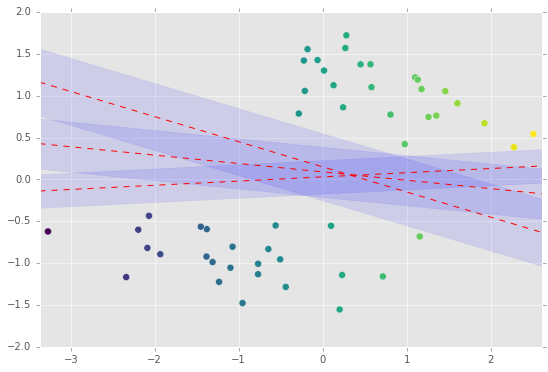

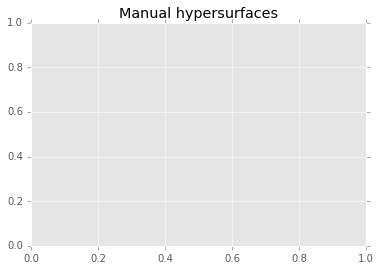

In [3]:
plt.figure(figsize=(9, 6))
plt.scatter(X[:,0], X[:, 1], c = X[:,0], cmap='viridis', s=50)

x_line = np.linspace(np.min(X) - 0.1, np.max(X) + 0.1)

for a, b, w in [(-0.1, 0.09, 0.3), (0.05, 0.03, 0.2), (-0.3, 0.15, 0.4)]:
    y_line = a*x_line + b
    plt.plot(x_line, y_line, '--r')
    plt.fill_between(x_line, y_line - w, y_line + w, color='b', alpha = 0.1)
plt.xlim(x_line[0], x_line[-1])
plt.show()
plt.title("Manual hypersurfaces")

In [4]:
from sklearn.svm import SVC

# Fitting linear SVM model

lin_svm = SVC(kernel='linear', C=10).fit(X, y)

In [5]:
print("Margin of (-1, 0) and (1, 0): ", lin_svm.decision_function([[-1, 0]]), lin_svm.decision_function([[1, 0]]))

Margin of (-1, 0) and (1, 0):  [-0.22172707] [ 0.22609642]


In [6]:
print("Support vectors:\n", lin_svm.support_vectors_)

Support vectors:
 [[ 1.1570521  -0.68200572]
 [ 0.10049452 -0.55406725]
 [ 0.97778644  0.42105939]]


In [7]:
def plot_svc_decision_function(clf, ax=None):
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([[xi, yj]])
    # plot the margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '-.'])

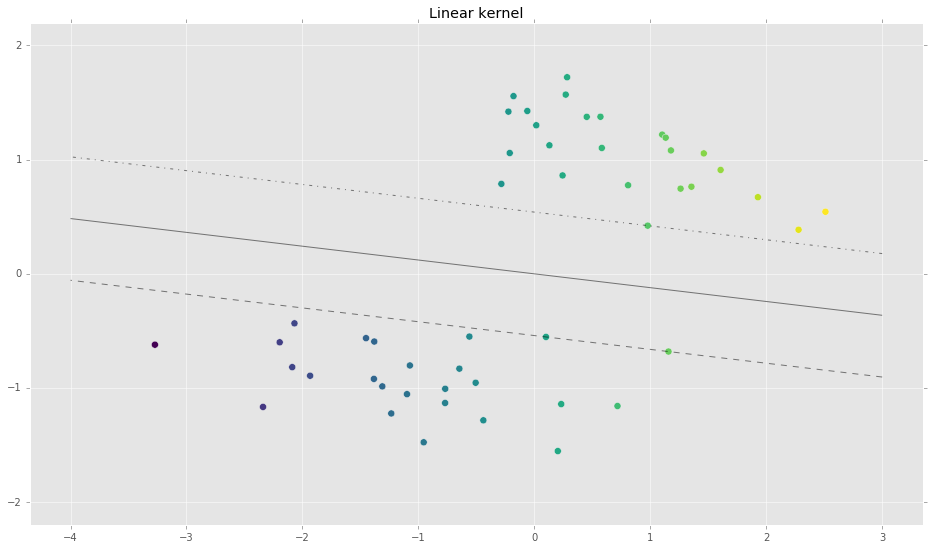

In [8]:
plt.figure(figsize=(16, 9))
plt.scatter(X[:,0], X[:, 1], c = X[:,0], cmap='viridis', s=50)
plot_svc_decision_function(lin_svm)
plt.title("Linear kernel")

In [9]:
poly_svm = SVC(kernel='poly', C=15).fit(X, y)

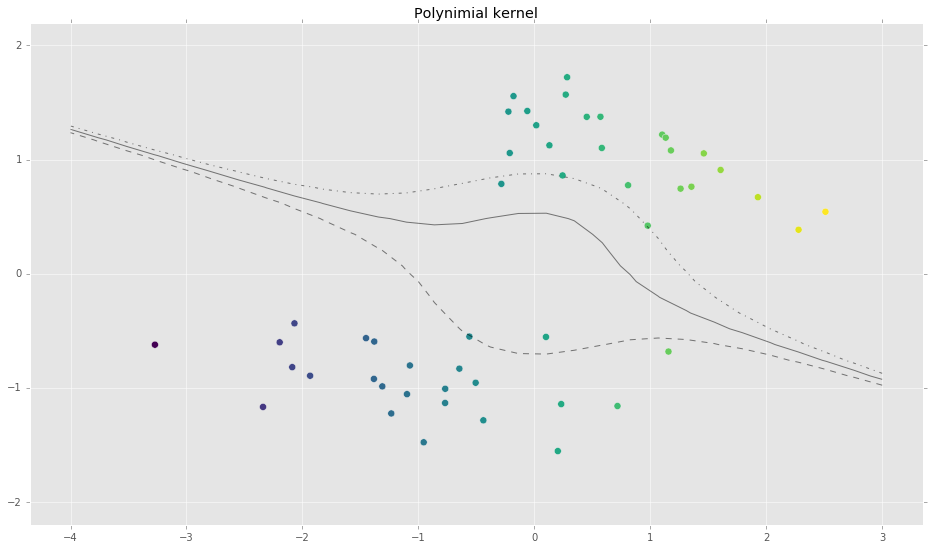

In [10]:
plt.figure(figsize=(16, 9))
plt.scatter(X[:,0], X[:, 1], c = X[:,0], cmap='viridis', s=50)
plot_svc_decision_function(poly_svm)
plt.title("Polynimial kernel")

In [11]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target

# Dataset for decision function visualization: we only keep the first two
# features in X and sub-sample the dataset to keep only 2 classes and
# make it a binary classification problem.

X_2d = X[:, :2]
X_2d = X_2d[y > 0]
y_2d = y[y > 0]
y_2d -= 1

In [12]:
# It is usually a good idea to scale the data for SVM training.
# We are cheating a bit in this example in scaling all of the data,
# instead of fitting the transformation on the training set and
# just applying it on the test set.

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_2d = scaler.fit_transform(X_2d)

In [13]:
# It is usually a good idea to scale the data for SVM training.
# We are cheating a bit in this example in scaling all of the data,
# instead of fitting the transformation on the training set and
# just applying it on the test set.

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_2d = scaler.fit_transform(X_2d)

In [14]:
#############################################################################
# Train classifiers
#
# For an initial search, a logarithmic grid with basis
# 10 is often helpful. Using a basis of 2, a finer
# tuning can be achieved but at a much higher cost.

from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(y, n_iter=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 1.0, 'gamma': 0.10000000000000001} with a score of 0.97


In [15]:
# plot the scores of the grid
# grid_scores_ contains parameter settings and scores
# We extract just the scores
scores = [x[1] for x in grid.grid_scores_]
scores = np.array(scores).reshape(len(C_range), len(gamma_range))

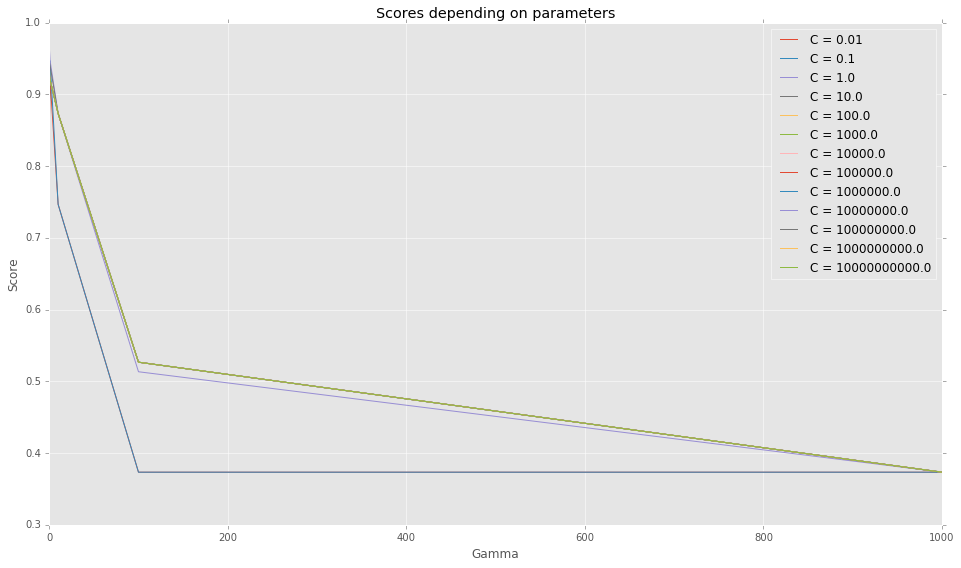

In [16]:
plt.figure(figsize=(16, 9))
for i, j in enumerate(C_range):
    plt.plot(gamma_range, scores[i], label = "C = "  + str(j))
plt.legend()
plt.xlabel('Gamma')
plt.ylabel('Score')
plt.title("Scores depending on parameters")

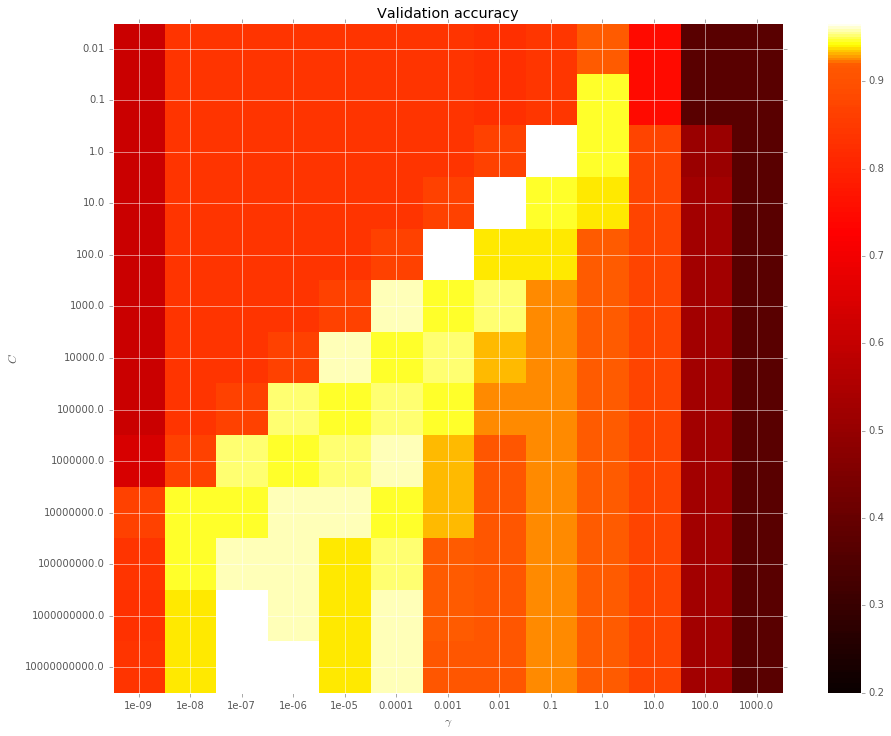

In [17]:
from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
# Draw heatmap of the validation accuracy as a function of gamma and C
#
# The score are encoded as colors with the hot colormap which varies from dark
# red to bright yellow. As the most interesting scores are all located in the
# 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
# as to make it easier to visualize the small variations of score values in the
# interesting range while not brutally collapsing all the low score values to
# the same color.

plt.figure(figsize=(16, 12))
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('$\gamma$')
plt.ylabel('$C$')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=0)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

In [18]:
# Now we need to fit a classifier for all parameters in the 2d version
# (we use a smaller set of parameters here because it takes a while to train)

C_2d_range = [1e-2, 1, 1e2]
gamma_2d_range = [1e-1, 1, 1e1]
classifiers = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X_2d, y_2d)
        classifiers.append((C, gamma, clf))

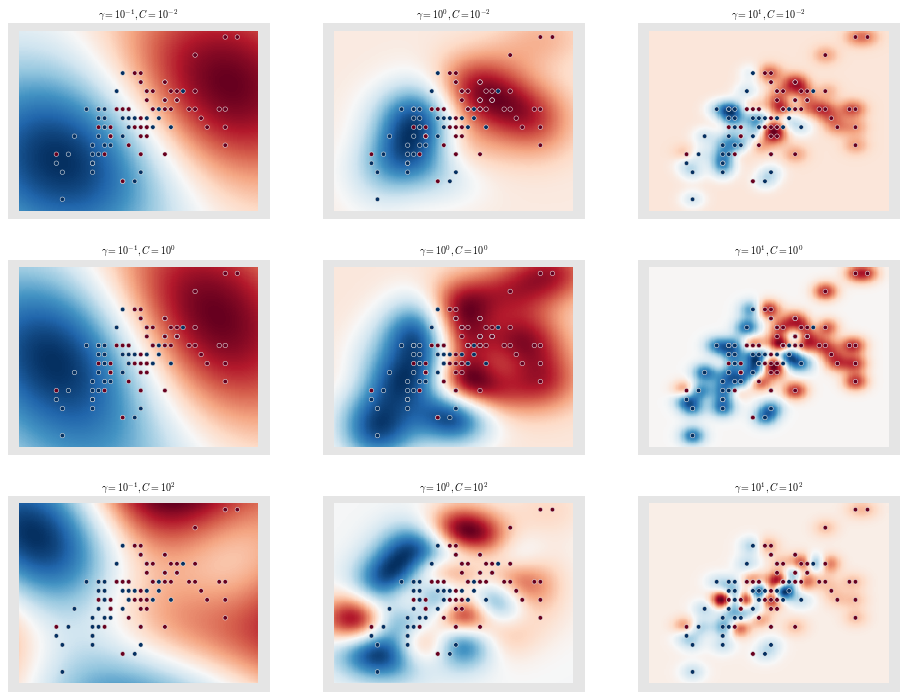

In [19]:
##############################################################################
# visualization
#
# draw visualization of parameter effects

plt.figure(figsize=(16, 12))
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
for (k, (C, gamma, clf)) in enumerate(classifiers):
    # evaluate decision function in a grid
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # visualize decision function for these parameters
    plt.subplot(len(C_2d_range), len(gamma_2d_range), k + 1)
    plt.title("$\gamma=10^{%d}, C=10^{%d}$" % (np.log10(gamma), np.log10(C)),
              size='medium')

    # visualize parameter's effect on decision function
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_2d, cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

<function __main__.plot_3D>

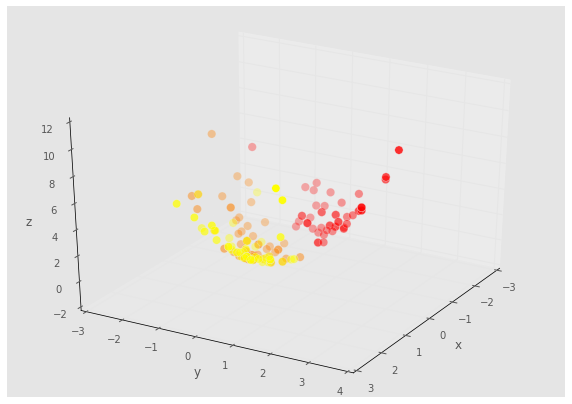

In [20]:
from IPython.html.widgets import interact
from mpl_toolkits import mplot3d

r = X[:, 0] ** 2 + X[:, 1] ** 2

def plot_3D(elev=30, azim=30):
    plt.figure(figsize=(10,7))
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=70, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180))